## Imports <a id="imports"></a>

In [2]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator

from qiskit_aer import AerSimulator

from qc_grader.challenges.qgss_2025 import grade_lab0_ex1, grade_lab0_ex2

## Sanity check <a id="sanity-check"></a>

Let's now create a very simple quantum circuit to check that everything is working as expected.

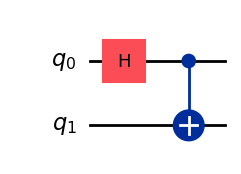

In [3]:
# Create a new circuit with a single qubit
qc = QuantumCircuit(2)
# Add a H gate to qubit 0
qc.h(0)
# Add a CNOT gate to qubit 1
qc.cx(0, 1)
# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")

The output you see represents a quantum circuit that produces a Bell state:

$$|Bell\rangle=\frac{|00\rangle+|11\rangle}{\sqrt{2}}$$

# Generate a three-qubit GHZ state using Qiskit patterns <a id="ghz"></a>

Now, we will follow this episode of [Coding with Qiskit](https://www.youtube.com/watch?v=93-zLTppFZw&list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi&index=4) to guide you through the process of generating a three-qubit GHZ state using [Qiskit patterns](https://quantum.cloud.ibm.com/docs/en/guides/intro-to-patterns). 

A Qiskit pattern is a general framework for breaking down domain-specific problems and contextualizing required capabilities in stages. This allows for the seamless composability of new capabilities developed by IBM Quantum researchers (and others) and enables a future in which quantum computing tasks are performed by powerful heterogenous (CPU/GPU/QPU) computing infrastructure. 

The four steps of a Qiskit pattern are as follows:

1. **Map** problem to quantum circuits and operators
2. **Optimize** for target hardware
3. **Execute** on target hardware
4. **Post-process** results


## Step 1. Map <a id="map"></a>

The Greenberger–Horne–Zeilinger (GHZ) state is the extension to three (or more) qubits to the maximally entangled state characteristic of the Bell state depicted above. That means that the GHZ state is:

$$
|GHZ\rangle = \frac{|000\rangle+|111\rangle}{\sqrt{2}}.
$$

One of the interesting features of the GHZ state is that there are different and equivalent ways to build it using a quantum circuit. In Exercise 1 you will do it in one of the most common ways.

<a id="Exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Design a GHZ state</b> 

This is your first exercise of the Summer School! Exciting, huh?

In this exercise, you will design a GHZ state following the steps below:

1. Apply a Hadamard gate to qubit 0, putting it into a superposition. 
2. Apply a CNOT gate between qubits 0 and 1.
3. Apply a CNOT gate between qubits 1 and 2.

</div>

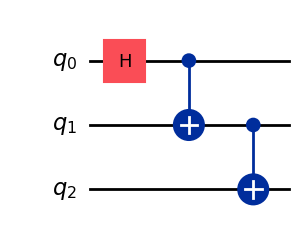

In [4]:
qc = QuantumCircuit(3)

### WRITE YOUR CODE BELOW HERE ###
# Add a H gate to qubit 0
qc.h(0)

# Add a CNOT gate to qubits 0 and 1
qc.cx(0,1)

# Add a CNOT gate to qubits 1 and 2
qc.cx(1,2)

### YOUR CODE FINISHES HERE    ###

# Return a drawing of the circuit using MatPlotLib ("mpl").
qc.draw("mpl")

## Step 2. Optimize <a id="optimize"></a>

Well done designing the circuit!

In this case, the circuit is very shallow, and it is not possible to further simplify it or reduce the required number of gates that are needed to build the GHZ state. However, there are other scenarios in which optimizing the circuit is key.

There may be situations where you face restrictions in how your quantum circuit can be designed. For example, when running circuits on quantum hardware, you might find connectivity constraints between qubits. This means that some qubits may not be physically connected, so you will need to think of a smart way to implement gates that produce the desired quantum state. Luckily for us, this is where the Qiskit transpiler comes to the rescue! You can provide the desired circuit along with the device's constraints to the transpiler and it will handle the optimization for you.

Let us consider, for the GHZ state, a situation in which we are limited to interactions only between qubits 0 and 1 and qubits 0 and 2, but not between qubits 1 and 2. We can introduce these constraints to the transpiler using the `transpile` function.

<a id="Exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2: Transpile a GHZ state</b> 

In this second exercise you are asked to transpile the previous GHZ state with the mentioned connectivity constraints:

- Qubit 0 <---> Qubit 1
- Qubit 0 <---> Qubit 2
- ~~Qubit 1 <---> Qubit 2~~

</div>

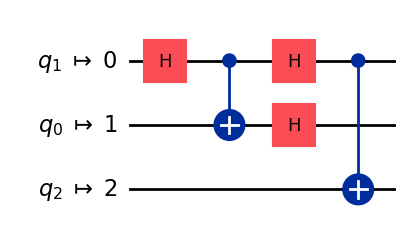

In [5]:
### WRITE YOUR CODE BELOW HERE ###
# Write the coupling map of connections between qubits 0 and 1 and 0 and 2 as a list of pairs: [[0,1],...]
coupling_map = [[0,1],[0,2]]

# Transpile the quantum circuit `qc` using the `transpile` function and the coupling map
from qiskit import transpile
qc_transpiled = transpile(qc, coupling_map=coupling_map)
### YOUR CODE FINISHES HERE    ###

qc_transpiled.draw("mpl")

## Step 3. Execute <a id="execute"></a>

The next step is exciting - we are going to run the quantum circuit using Qiskit Runtime! 

We will do that using the two [Qiskit primitives](https://quantum.cloud.ibm.com/docs/guides/primitives):
1. **Sampler** samples the output register from the execution of one or more quantum circuits. Its output is counts on per-shot measurements. 
2. **Estimator** computes the expectation value of one or more observables with respect to the states generated by the quantum circuit. Its output consist of the expectation values along with their standard errors.

First, we execute our circuit using the Sampler, then save the results as the variable `results_sampler`. 

In [11]:
# Add measurement operations
qc.measure_all()

# Set up the backend
backend = AerSimulator()

# Set up the sampler
sampler = Sampler(mode=backend)

# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
job = sampler.run(pm.run([qc]))

# Get the results
results_sampler = job.result()

Now, we run our circuit using the Estimator primitive, then save the results as the variable `results_estimator`.

In [12]:
# Set up the Estimator
estimator = Estimator(mode=backend)

# Define some observables
ZZZ = SparsePauliOp("ZZZ")
ZZX = SparsePauliOp("ZZX")
ZII = SparsePauliOp("ZII")
XXI = SparsePauliOp("XXI")
ZZI = SparsePauliOp("ZZI")
III = SparsePauliOp("III")
observables = [ZZZ, ZZX, ZII, XXI, ZZI, III]

# Submit the circuit to Estimator
pub = (qc, observables)
job = estimator.run(pubs=[pub])

# Get the results
results_estimator = job.result()

Next is the final step of Qiskit patterns, where we will visualize our results.

## Step 4. Post-process <a id="post-process"></a>

Finally, the last step of Qiskit patterns is to post-process the information we have gathered from the execution of the quantum circuit.

First we visualize the results from the Sampler. We can visualize the counts with a histogram plot and quickly see how the two possible quantum states are measured with a probability of 50%.

  Outcomes : {'000': 520, '111': 504}


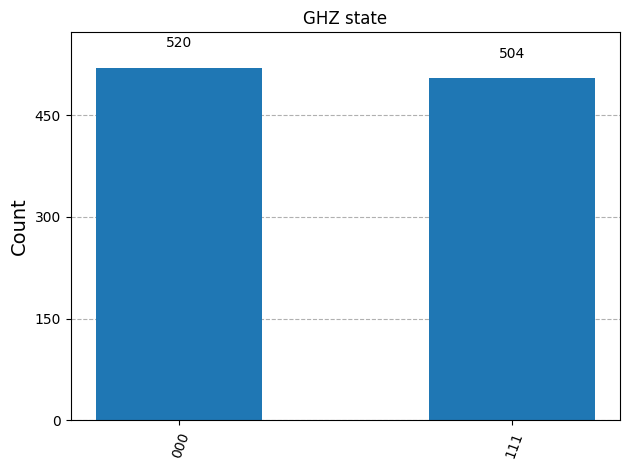

In [13]:
counts_list = results_sampler[0].data.meas.get_counts()
print(f"  Outcomes : {counts_list}")
display(plot_histogram(counts_list, title="GHZ state"))

Now we can visualize the results of the Estimator.

Expectation values: [('ZZZ', np.float64(-0.01171875)), ('ZZX', np.float64(0.0029296875)), ('ZII', np.float64(-0.01416015625)), ('XXI', np.float64(-0.02978515625)), ('ZZI', np.float64(1.0)), ('III', np.float64(1.0))]


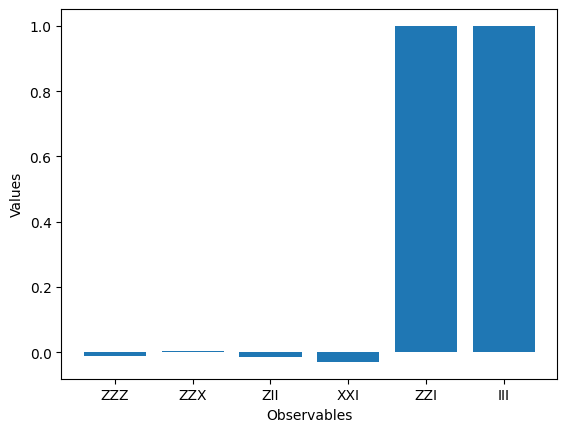

In [14]:
exp_values = results_estimator[0].data.evs
observables_list = ["ZZZ", "ZZX", "ZII", "XXI", "ZZI", "III"]
print(f"Expectation values: {list(zip(observables_list, exp_values))}")

# Set up our plot
container = plt.bar(observables_list, exp_values, width=0.8)
# Label each axis
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

We see that the observables $ZZI$ and $III$ have an expectation value of 1, since $ZZI$ introduces two minus signs that cancel out, and $III$ acts as the identity, leaving the GHZ state unchanged. The rest of the observables have an expectation value of 0, since their $Z$ operators introduce an odd number of minus signs, or the $X$ operators flip a number of qubits that make the overlapping states orthogonal.

## Bonus challenge: Run GHZ on hardware <a id="bonus"></a>

To execute a quantum circuit on a quantum computer using Qiskit, we first need to define the quantum backend. We could manually select a specific quantum computer we want to use out of the ones available from IBM Quantum. However, sometimes it is more convenient to select the machine that is least busy at the moment to ensure a fast execution. That's where the method `least_busy` is helpful.

In [15]:
# Define the service. This allows you to access IBM QPUs.
service = QiskitRuntimeService(name="qgss-2025")

# Get a backend
backend = service.least_busy(operational=True, simulator=False)
print(f"We are using the {backend.name} quantum computer")

We are using the ibm_torino quantum computer


The next call illustrates how easy it is to execute quantum circuits on hardware with `QiskitRuntimeService`. Once we have selected the backend in the cell above, we can simply copy and paste the same lines of code that we wrote for the Sampler simulator, including post-processing and visualization.

In [16]:
### WRITE YOUR CODE BELOW HERE ###
# Step 1. Map
# You should have created a GHZ circuit above and assigned with variable `qc`

# Step 2. Optimize
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
qc_transpiled = pm.run(qc)

In [20]:
# Step 3. Execute
sampler = Sampler(mode=backend)
job = sampler.run([qc_transpiled])

Outcomes : {'000': 520, '111': 504}


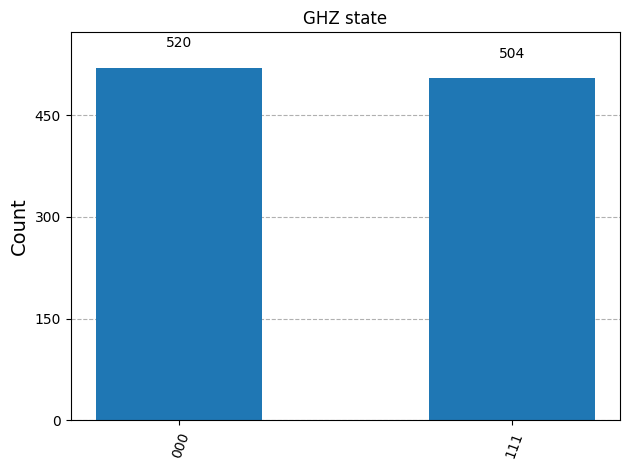

In [21]:
# Step 4. Post-process
results = job.result()
counts_list = results_sampler[0].data.meas.get_counts()
### YOUR CODE FINISHES HERE    ###

print(f"Outcomes : {counts_list}")
plot_histogram(counts_list,title='GHZ state')

##And we're done :)